In [4]:
import numpy as np
import random
from typing import List, Dict, Optional, Tuple, Callable, Any
from dataclasses import asdict, dataclass
import json
import re

@dataclass
class NodeStats:
    """Statistics for a node in the MCTS tree"""
    visits: int
    value: float
    success_rate: float
    depth: int
    is_terminal: bool
    num_children: int

    def to_dict(self) -> Dict:
        return asdict(self)

@dataclass
class MCTSNode:
    state: str  # Current solution state
    parent: Optional['MCTSNode']
    children: List['MCTSNode']
    visits: int
    value: float
    untried_actions: List[str]  # Possible next steps
    is_terminal: bool
    correct_continuations: int = 0
    total_continuations: int = 0

    def get_stats(self) -> NodeStats:
        """Get statistics for this node"""
        return NodeStats(
            visits=self.visits,
            value=self.value,
            success_rate=self.value / max(self.visits, 1),
            depth=self.get_depth(),
            is_terminal=self.is_terminal,
            num_children=len(self.children)
        )

    def get_depth(self) -> int:
        """Get the depth of this node in the tree"""
        depth = 0
        node = self
        while node.parent:
            depth += 1
            node = node.parent
        return depth

    def to_dict(self) -> Dict:
        """Convert node to dictionary representation"""
        return {
            'state': self.state,
            'stats': self.get_stats().to_dict(),
            'children': [child.to_dict() for child in self.children]
        }

class LLMClient:
    """Wrapper for OpenAI-compatible API clients."""
    def __init__(
        self,
        client,
        model: str,
        default_temperature: float = 0.7,
        default_max_tokens: int = 1024,
        system_prompt: Optional[str] = None
    ):
        self.client = client
        self.model = model
        self.default_temperature = default_temperature
        self.default_max_tokens = default_max_tokens
        self.system_prompt = system_prompt

    def generate(
        self,
        prompt: str,
        temperature: Optional[float] = None,
        max_tokens: Optional[int] = None,
        system_prompt: Optional[str] = None,
        n: int = 1
    ) -> List[str]:
        """Generate completions with consistent interface."""
        messages = []

        # Use provided system prompt or fall back to default
        current_system_prompt = system_prompt or self.system_prompt
        if current_system_prompt:
            messages.append({"role": "system", "content": current_system_prompt})

        messages.append({"role": "user", "content": prompt})

        try:
            response = self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature if temperature is not None else self.default_temperature,
                max_tokens=max_tokens if max_tokens is not None else self.default_max_tokens,
                n=n
            )
            return [choice.message.content.strip() for choice in response.choices]
        except Exception as e:
            return [""] * n

class MCTS:
    def __init__(self,
                 llm_client: LLMClient,
                 exploration_weight: float = 1.414,
                 num_rollouts: int = 5,
                 max_depth: int = 5,
                 branching_factor: int = 3,
                 c: float = 1.):
        """
        Initialize MCTS for LLM-based problem solving.

        Args:
            llm_client: LLMClient instance
            exploration_weight: UCB1 exploration parameter
            num_rollouts: Number of Monte Carlo rollouts for evaluation
            max_depth: Maximum depth of the search tree
        """
        self.llm_client = llm_client
        self.exploration_weight = exploration_weight
        self.num_rollouts = num_rollouts
        self.max_depth = max_depth
        self.search_tree = None
        self.branching_factor = branching_factor
        self.c = c

    def ucb1(self, node: MCTSNode, parent_visits: int) -> float:
        """Calculate UCB1 value for node selection."""
        if node.visits == 0:
            return float('inf')

        exploitation = node.value / node.visits
        exploration = self.exploration_weight * np.sqrt(np.log(parent_visits) / node.visits)
        return exploitation + self.c * exploration

    def get_possible_actions(self, state: str, problem: str) -> List[str]:
        """Get possible next steps from current state using LLM."""
        prompt = f"""Given the math problem and current partial solution:
        Problem: {problem}
        Current solution steps:
        {state}\n\n"""

        prompt += r"""Generate the next logical step in the solution. Be concise and direct.
        - Each step should be a single, clear logical or math operation
        - Don't repeat previous steps
        - If during the next step you get the final answer for the problem, you immediately output this answer in \boxed\{\}. This is very important!

        Next step:"""

        responses = self.llm_client.generate(prompt, n=self.branching_factor)
        return [step for step in responses if step.strip()]

    def evaluate_partial_solution(self,
                               state: str,
                               problem: str,
                               evaluate_continuation: Callable[[str, str], Tuple[int, int]]) -> Tuple[int, int]:
        """
        Evaluate partial solution using the provided evaluation function.
        Returns (correct_continuations, total_continuations)
        """
        return evaluate_continuation(state, problem)

    def select(self, node: MCTSNode) -> MCTSNode:
        """Select most promising node using UCB1."""
        while node.children and not node.is_terminal:
            if node.untried_actions:
                return node

            node = max(node.children,
                      key=lambda n: self.ucb1(n, node.visits))
        return node

    def expand(self,
              node: MCTSNode,
              problem: str,
              evaluate_continuation: Callable[[str, str], Tuple[int, int]]) -> Optional[MCTSNode]:
        """Expand node by adding a child with an untried action."""

        if not node.untried_actions or node.is_terminal:
            return None

        action = random.choice(node.untried_actions)
        node.untried_actions.remove(action)

        new_state = f"{node.state}\n{action}" if node.state else action
        possible_actions = self.get_possible_actions(new_state, problem)

        actual_depth = node.get_depth() + 1  # +1 for the child we're creating
        is_terminal = (actual_depth >= self.max_depth) or ("\\boxed" in new_state)
        correct_cont, total_cont = self.evaluate_partial_solution(
            new_state, problem, evaluate_continuation)

        child = MCTSNode(
            state=new_state,
            parent=node,
            children=[],
            visits=0,
            value=0.0,
            untried_actions=possible_actions,
            is_terminal=is_terminal,
            correct_continuations=correct_cont,
            total_continuations=total_cont
        )

        node.children.append(child)
        return child

    def rollout(self,
            node: MCTSNode,
            problem: str,
            evaluate_continuation: Callable[[str, str], Tuple[int, int]]) -> float:
        """
        Run multiple rollouts by generating full continuations from the node's state.
        For each rollout, generate a complete solution by calling the LLM,
        then evaluate that complete solution using the provided deterministic evaluator.
        Returns an average score (ratio of correct to total continuations).
        """
        # Construct a prompt that asks the LLM to complete the chain-of-thought
        prompt = f"""You are given the math problem and current partial solution:
        Problem: {problem}
        Current solution steps:
        {node.state}\n\n"""

        prompt += r"""Complete the solution and output the final answer in \boxed\{\}"""

        # Generate multiple full continuations
        responses = self.llm_client.generate(prompt, n=self.num_rollouts)

        scores = []
        for response in responses:
            # Construct the full solution by appending the generated continuation
            full_solution = f"{node.state}\n{response}"

            # Evaluate the full solution using the deterministic evaluator
            correct, total = evaluate_continuation(full_solution, problem)
            score = correct / max(total, 1)
            scores.append(score)

        # Return the average score over all generated completions
        aggregated_score = sum(scores) / len(scores) if scores else 0.0
        return aggregated_score

    def backpropagate(self, node: MCTSNode, value: float):
        """Backpropagate value up the tree."""
        while node:
            node.visits += 1
            node.value += value
            node = node.parent

    def search(self,
              problem: str,
              evaluate_continuation: Callable[[str, str], Tuple[int, int]],
              initial_state: str = "",
              num_iterations: int = 100,
              verbose: bool = False) -> Tuple[str, MCTSNode]:
        """
        Perform MCTS search to find solution.

        Args:
            problem: Problem description
            evaluate_continuation: Function to evaluate solution continuations
            initial_state: Starting point for solution
            num_iterations: Number of MCTS iterations
            verbose: Whether to print detailed logs

        Returns:
            Best solution found and the search tree root
        """
        possible_actions = self.get_possible_actions(initial_state, problem)
        root = MCTSNode(
            state=initial_state,
            parent=None,
            children=[],
            visits=0,
            value=0.0,
            untried_actions=possible_actions,
            is_terminal=False
        )

        for iteration in range(num_iterations):
            node = self.select(root)
            child = self.expand(node, problem, evaluate_continuation)

            if child:
                # Use multi-rollout simulation to get a robust estimate
                simulation_value = self.rollout(child, problem, evaluate_continuation)
                self.backpropagate(child, simulation_value)

            if verbose and iteration % 5 == 0:
                tree_info = self.get_tree_summary(root)
                print(f"\nIteration {iteration} - Tree Statistics:")
                print(json.dumps(tree_info['statistics'], indent=2))

        # Store the search tree for later analysis
        self.search_tree = root

        best_path = self._get_best_path(root)
        final_solution = best_path[-1]['state']
        return final_solution, root

    def get_tree_summary(self, node: MCTSNode, max_depth: Optional[int] = None) -> Dict:
        """
        Get a summary of the search tree up to max_depth.
        If max_depth is None, returns the entire tree.
        """
        return {
            'tree_structure': node.to_dict(),
            'statistics': {
                'total_nodes': self._count_nodes(node),
                'max_depth': self._get_max_depth(node),
                'leaf_nodes': self._count_leaf_nodes(node),
                'avg_branching': self._get_avg_branching(node),
                'best_path': self._get_best_path(node)
            }
        }

    def _count_nodes(self, node: MCTSNode) -> int:
        """Count total nodes in tree"""
        return 1 + sum(self._count_nodes(child) for child in node.children)

    def _get_max_depth(self, node: MCTSNode) -> int:
        """Get maximum depth of tree"""
        if not node.children:
            return 0
        return 1 + max(self._get_max_depth(child) for child in node.children)

    def _count_leaf_nodes(self, node: MCTSNode) -> int:
        """Count leaf nodes in tree"""
        if not node.children:
            return 1
        return sum(self._count_leaf_nodes(child) for child in node.children)

    def _get_avg_branching(self, node: MCTSNode) -> float:
        """Calculate average branching factor"""
        total_nodes = self._count_nodes(node)
        non_leaf_nodes = total_nodes - self._count_leaf_nodes(node)
        if non_leaf_nodes == 0:
            return 0.0
        return (total_nodes - 1) / non_leaf_nodes

    def _get_best_path(self, node: MCTSNode) -> List[Dict]:
        """Get the path with highest value that leads to a terminal state"""
        path = []
        current = node
        while current:
            path.append({
                'state': current.state,
                'stats': current.get_stats().to_dict()
            })
            if not current.children:
                break

            # Among children that have been visited at least once,
            # choose the one with highest success rate
            visited_children = [c for c in current.children if c.visits > 0]
            if not visited_children:
                break

            # If any child is terminal with a good score, prefer it
            terminal_children = [c for c in visited_children if c.is_terminal and c.value/max(c.visits, 1) > 0]
            if terminal_children:
                current = max(terminal_children,
                             key=lambda n: n.value / max(n.visits, 1))
            else:
                current = max(visited_children,
                         key=lambda n: n.value / max(n.visits, 1))
        return path

# Example evaluation function:
def answer_comparison_evaluator(state: str, problem: str,
                               expected_answer: float) -> Tuple[int, int]:
    """Evaluates solution by comparing extracted answers with expected answer."""
    # Extract answer from \boxed{} in the solution
    answer_match = re.search(r'oxed\{([^}]+)\}', state)
    if not answer_match:
        return (0, 1)

    solution_answer = answer_match.group(1).strip().replace("\\", "").strip()
    try:
        solution_answer = float(solution_answer)
    except ValueError:
        return (0, 1)

    return (1, 1) if np.abs(solution_answer - expected_answer) < 1e-10 else (0, 1)


In [8]:
from openai import OpenAI
import os

# 1. Load Nebius API key
with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()
    os.environ["NEBIUS_API_KEY"] = nebius_api_key

# Initialize the LLM client
async_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)

# Create the LLM client wrapper
llm_client = LLMClient(
    client=async_client,
    model="meta-llama/Meta-Llama-3.1-70B-Instruct",
    system_prompt=None,
)

# Initialize MCTS with the client
mcts = MCTS(
    llm_client=llm_client,
    max_depth=10,
    num_rollouts=5,
    c=0.5
)

In [9]:
# Run the search
solution, tree = mcts.search(
    problem="Inside a circle, two parallel chords are 6 units apart. One chord has length 14 and the other has length 10. Find the square of the radius of the circle.",
    evaluate_continuation=lambda state, problem: answer_comparison_evaluator(state, problem, 50.0),
    num_iterations=100,
    verbose=True
)

print(solution)


Iteration 0 - Tree Statistics:
{
  "total_nodes": 2,
  "max_depth": 1,
  "leaf_nodes": 1,
  "avg_branching": 1.0,
  "best_path": [
    {
      "state": "",
      "stats": {
        "visits": 1,
        "value": 0.4,
        "success_rate": 0.4,
        "depth": 0,
        "is_terminal": false,
        "num_children": 1
      }
    },
    {
      "state": "Let's denote the radius of the circle as $r$. To solve this problem, we can use the fact that the perpendicular bisectors of the chords pass through the center of the circle. \n\nNext step: Draw a diagram with the circle, the two parallel chords, and the perpendicular bisectors of the chords, and label the points where the bisectors intersect the chords and the center of the circle.",
      "stats": {
        "visits": 1,
        "value": 0.4,
        "success_rate": 0.4,
        "depth": 1,
        "is_terminal": false,
        "num_children": 0
      }
    }
  ]
}

Iteration 5 - Tree Statistics:
{
  "total_nodes": 7,
  "max_depth":

C:\Users\vital\AppData\Local\Temp\ipykernel_17900\1484992525.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


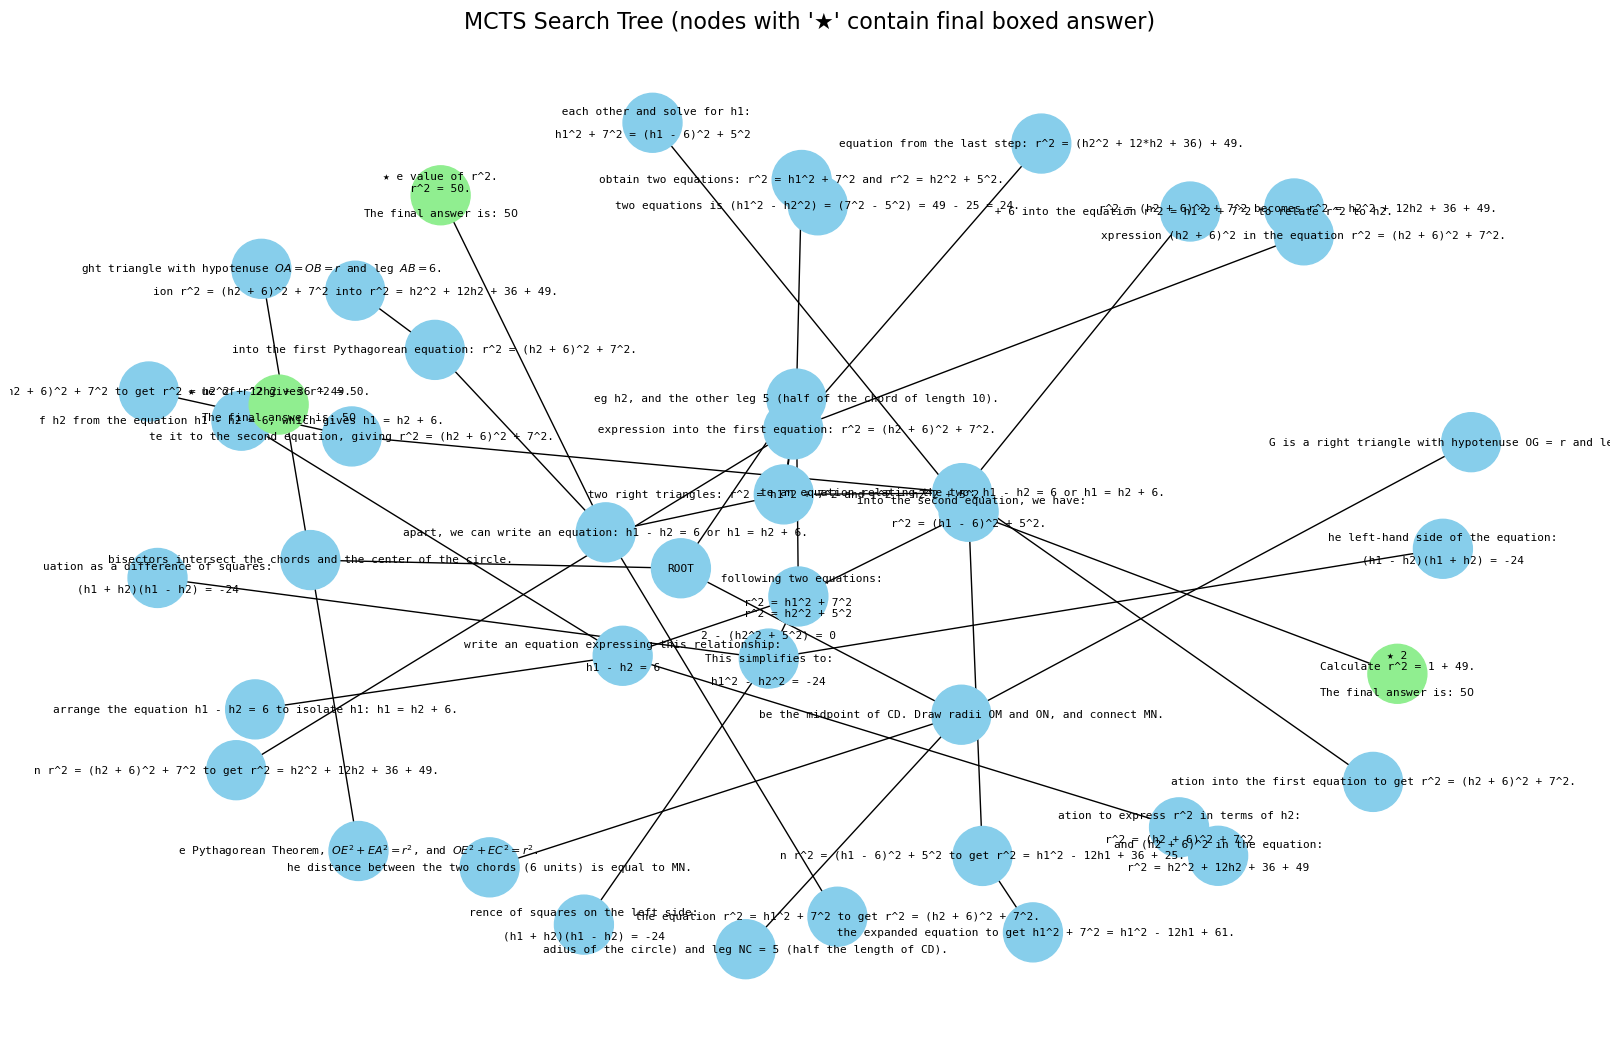

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import re

def remove_boxed(text):
    """Remove all \boxed{...} from a string."""
    return re.sub(r'\\boxed\{([^}]*)\}', r'\1', text)

def add_nodes_edges(G, node, parent_id=None, node_labels=None, answer_nodes=None, max_depth=5):
    """
    Recursively add nodes and edges to the graph from the MCTSNode tree.
    Highlights nodes containing the boxed answer.
    """
    node_id = id(node)
    if node_labels is not None:
        # Only use the last 60 chars for display (to avoid very long steps)
        label = remove_boxed(node.state[-60:]) if node.state else "ROOT"
        # Highlight terminal/answer node
        if '\\boxed{' in node.state:
            label = "★ " + label
            answer_nodes.append(node_id)
        node_labels[node_id] = label
    G.add_node(node_id)
    if parent_id is not None:
        G.add_edge(parent_id, node_id)
    # Limit the depth for visualization (optional, e.g. max_depth=5)
    if node.get_depth() < max_depth:
        for child in node.children:
            add_nodes_edges(G, child, node_id, node_labels, answer_nodes, max_depth)

def plot_mcts_tree(root, max_depth=5):
    G = nx.DiGraph()
    node_labels = {}
    answer_nodes = []
    add_nodes_edges(G, root, None, node_labels, answer_nodes, max_depth=max_depth)

    pos = nx.spring_layout(G, seed=42)  # or try nx.nx_agraph.graphviz_layout(G, prog='dot') for a tree layout if pygraphviz is installed

    # Color answer nodes differently
    color_map = []
    for node in G:
        if node in answer_nodes:
            color_map.append('lightgreen')
        else:
            color_map.append('skyblue')

    plt.figure(figsize=(16, 10))
    nx.draw(G, pos, labels=node_labels, with_labels=True, node_color=color_map, node_size=1800, font_size=8, font_family='monospace', arrows=False)
    plt.title("MCTS Search Tree (nodes with '★' contain final boxed answer)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---- Usage ----
# Assuming 'tree' is your MCTSNode root after running search
plot_mcts_tree(tree, max_depth=5)  # Set max_depth to keep the graph readable
